In [32]:
%matplotlib inline
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [69]:
x, sr = librosa.load('examples/Love For Sale.wav')
ipd.Audio(x, rate=sr)

In [70]:
fmin = librosa.midi_to_hz(36)
hop_length = 512

In [73]:
# analisando primeiramente apenas um quarto da m√∫sica (aprox. 15 segundos)
X = x[:int(len(x)/4)]
len(X)

303185

### Implementing basic approach described in [1].
[1] https://musicinformationretrieval.com/index.html

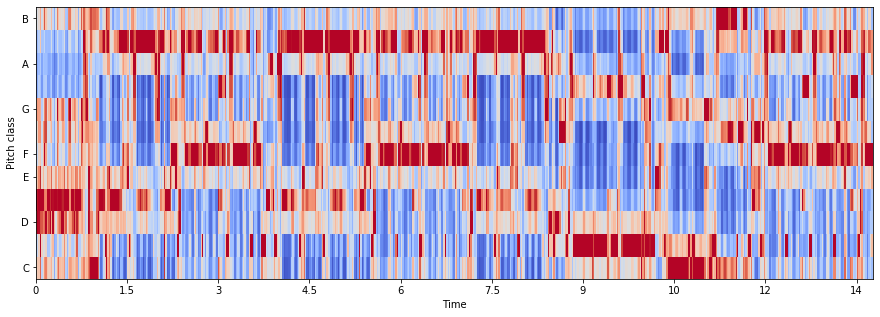

In [74]:
chromagram = librosa.feature.chroma_stft(X, sr=sr, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, 
                         x_axis='time', 
                         y_axis='chroma', 
                         hop_length=hop_length, 
                         cmap='coolwarm')

In [28]:
# fig, ax = plt.subplots()
# img = librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time', ax=ax)
# fig.colorbar(img, ax=ax)
# ax.set(title='Chromagram')

In [75]:
chromagram

array([[0.6090153 , 0.62010074, 0.6306269 , ..., 0.35640946, 0.40927345,
        0.326042  ],
       [0.3614302 , 0.43508297, 0.5920128 , ..., 0.28406802, 0.52295035,
        0.66260344],
       [0.8400219 , 1.        , 0.9887747 , ..., 0.28671646, 0.37662214,
        0.37235746],
       ...,
       [0.25893253, 0.26153296, 0.32293183, ..., 0.5079158 , 0.52254194,
        0.7805718 ],
       [0.3190674 , 0.319088  , 0.40674272, ..., 0.8816635 , 0.8571883 ,
        0.77882427],
       [0.51800126, 0.49913153, 0.551155  , ..., 0.5792834 , 0.5642838 ,
        0.3231535 ]], dtype=float32)

In [102]:
def get_chord_labels(nonchord=False):
    """Gera as labels pros acordes menores e maiores

    returns:
        chord_labels (list)
    """
    chord_labels_maj = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    chord_labels_min = [s + 'm' for s in chord_labels_maj]
    chord_labels = chord_labels_maj + chord_labels_min
    if nonchord is True:
        chord_labels = chord_labels_maj + ['N']
    return chord_labels

def generate_chord_templates(nonchord=False):
    """Gera os acordes como vetores de 0 e 1.

    returns:
        chord_templates (np.ndarray)
    """
    template_cmaj = np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]).T
    template_cmin = np.array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]).T
    num_chord = 24
    if nonchord:
        num_chord = 25
    chord_templates = np.ones((12, num_chord))
    for shift in range(12):
        chord_templates[:, shift] = np.roll(template_cmaj, shift)
        chord_templates[:, shift+12] = np.roll(template_cmin, shift)
    return chord_templates

In [110]:
chord_templates = generate_chord_templates(nonchord=False)
# chord_templates.transpose()

chord_labels = get_chord_labels(nonchord=False)
chord_labels

['C',
 'C#',
 'D',
 'D#',
 'E',
 'F',
 'F#',
 'G',
 'G#',
 'A',
 'A#',
 'B',
 'Cm',
 'C#m',
 'Dm',
 'D#m',
 'Em',
 'Fm',
 'F#m',
 'Gm',
 'G#m',
 'Am',
 'A#m',
 'Bm']

In [111]:
chord_templates.transpose()

array([[1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1.,

In [82]:
def calculate_similarity(v1, v2):
    
    norm_v1 = norm(v1)
    norm_v2 = norm(v2)
    product = np.inner(v1, v2)
    sim = product/(norm_v2*norm_v2)
    
    return sim

In [83]:
chords_results = []
for chroma_vec in chromagram.transpose():
    chords_sims = []
    for chord_vec in chord_templates.transpose():
        sim_chord = calculate_similarity(chroma_vec, chord_vec)
        chords_sims.append(sim_chord)
    
    chords_sims = np.array(chords_sims)
    chord_out = np.argmin(chords_sims)
    chords_results.append(chord_out)

In [84]:
chord_templates.transpose()

array([[1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1.,

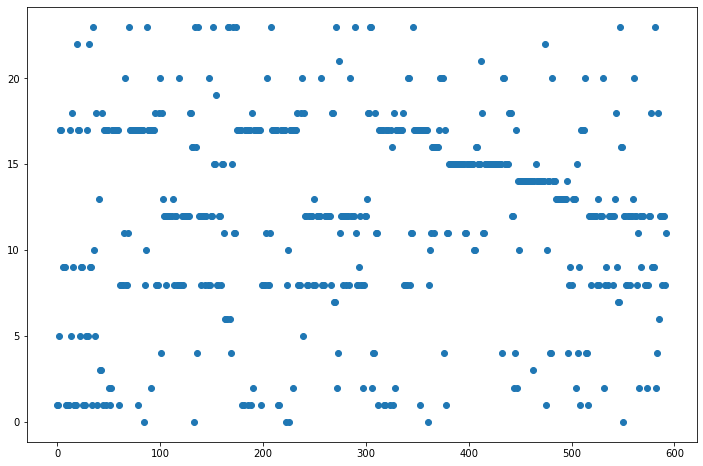

In [88]:
plt.figure(figsize=(12,8))
plt.plot(chords_results, 'o')
# plt.yticks(['C','C#','D','D#','E','F','F#','G','G#','A','A#','B',
#            'Cm','C#m','Dm','D#m','Em','Fm','F#m','Gm','G#m','Am','A#m','Bm'])

In [95]:
import libfmp.b
import libfmp.c3
import libfmp.c4

def chord_recognition_template(X, norm_sim='1', nonchord=False):
    """Conducts template-based chord recognition
    with major and minor triads (and possibly nonchord)

    Notebook: C5/C5S2_ChordRec_Templates.ipynb

    Args:
        X (np.ndarray): Chromagram
        norm_sim (str): Specifies norm used for normalizing chord similarity matrix (Default value = '1')
        nonchord (bool): If "True" then add nonchord template (Default value = False)

    Returns:
        chord_sim (np.ndarray): Chord similarity matrix
        chord_max (np.ndarray): Binarized chord similarity matrix only containing maximizing chord
    """
    chord_templates = generate_chord_templates()
    X_norm = libfmp.c3.normalize_feature_sequence(X, norm='2')
    chord_templates_norm = libfmp.c3.normalize_feature_sequence(chord_templates, norm='2')
    chord_sim = np.matmul(chord_templates_norm.T, X_norm)
    if norm_sim is not None:
        chord_sim = libfmp.c3.normalize_feature_sequence(chord_sim, norm=norm_sim)
    # chord_max = (chord_sim == chord_sim.max(axis=0)).astype(int)
    chord_max_index = np.argmax(chord_sim, axis=0)
    chord_max = np.zeros(chord_sim.shape).astype(np.int32)
    for n in range(chord_sim.shape[1]):
        chord_max[chord_max_index[n], n] = 1

    return chord_sim, chord_max

In [96]:
chord_sim, chord_max = chord_recognition_template(X, norm_sim='max')
chord_labels = get_chord_labels()

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Internal error at <numba.core.typeinfer.ExhaustIterConstraint object at 0x7f631ffece50>.
[1m[1mwrong tuple length for '$16load_attr.1': expected 2, got 1[0m
[0m[1m[1] During: typing of exhaust iter at /usr/local/lib/python3.8/dist-packages/libfmp/c3/c3s1_post_processing.py (49)[0m
Enable logging at debug level for details.
[1m
File "../../../../../../../usr/local/lib/python3.8/dist-packages/libfmp/c3/c3s1_post_processing.py", line 49:[0m
[1mdef normalize_feature_sequence(X, norm='2', threshold=0.0001, v=None):
    <source elided>

[1m    K, N = X.shape
[0m    [1m^[0m[0m
